In [29]:
import tensorflow as tf
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, SGD, Nadam
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model
from tensorflow.keras.applications import densenet
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
from keras import backend as K

import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [10]:
#Load data
nTest = 90
nPixels = 224

mds_360 = np.loadtxt("mds_360.txt")
categories = [i for i in range(30) for j in range(12)]

def load_images(directory, nPixels, preprocesser):
    X = []
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".jpg"):
                img = load_img(os.path.join(subdir, file), target_size=(nPixels, nPixels))
                x = img_to_array(img)
                X.append(x)
    X = np.stack(X)
    X = preprocesser(X)
    return X

X = load_images("360 Rocks", nPixels, lambda x: densenet.preprocess_input(np.expand_dims(x, axis=0)).squeeze())
(X_train_, X_test, 
 Y_train_, Y_test, 
 categories_train_, categories_test) = train_test_split(X, 
                                                        mds_360, 
                                                        categories,
                                                        test_size=nTest,
                                                        stratify=categories, 
                                                        random_state=0)

In [11]:
(X_train, X_validate, 
 Y_train, Y_validate) = train_test_split(X_train_, 
                                         Y_train_, 
                                         test_size=nTest,
                                         stratify=categories_train_, 
                                         random_state=0)

In [12]:
X_120 = load_images("120 Rocks", nPixels, lambda x: densenet.preprocess_input(np.expand_dims(x, axis=0)).squeeze())
Y_120 = np.loadtxt("mds_120.txt")

In [13]:
datagen = ImageDataGenerator(featurewise_center=False,
                    samplewise_center=False,
                    featurewise_std_normalization=False,
                    samplewise_std_normalization=False,
                    zca_whitening=False,
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    channel_shift_range=0.,
                    fill_mode='nearest',
                    cval=0.,
                    horizontal_flip=True,
                    vertical_flip=True)

In [23]:
from keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def __init__(self, filepath, monitor='val_loss', patience=20, warmup_epochs=5):
        super(CustomEarlyStopping, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.patience = patience
        self.warmup_epochs = warmup_epochs
        self.best_weights = None
        self.wait = 0
        self.stopped_epoch = 0
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get(self.monitor)
        if current_val_loss is None:
            return
        
        if epoch < self.warmup_epochs:
            # If still in warmup phase, do not trigger early stopping
            return
        
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.wait = 0
            # Save the weights of the best model
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.set_weights(self.best_weights)  # Load best weights
                self.model.save(self.filepath)  # Save the best model to a file
                self.model.stop_training = True  # Stop training

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Epoch {self.stopped_epoch + 1}: early stopping")
        else:
            print("Training completed without early stopping")


### Using Nadam Optimizer with He Normal Initialization with 500 Epochs and 2 - 256 Dense Layers for Finetuning

In [27]:
nDim = 8
nEpochs = 500
dropout = 0.5
nEnsemble = 10
          
nDense = 256
nLayers = 2
loglr = -2.2200654426745987

lr = 10 ** loglr

batch_size = 90

In [30]:
for e in range(nEnsemble):
    #Build model
    arch = densenet.DenseNet121(include_top=False, pooling='avg')
    for layer in arch.layers:
        layer.trainable = False    
    
    x = arch.output
    x = Dropout(dropout)(x)
    for lyr in range(nLayers):
        x = Dense(nDense, activation='relu', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout)(x)
    x = Dense(nDim)(x)
    
    model = Model(inputs=arch.input, outputs=x)
    
    #Initial training
    model.compile(loss='mean_squared_error', optimizer=Nadam(learning_rate=lr))
    
    filepath = 'intermediate_model_densenet_500_256_2.hdf5'
    custom_early_stopping = CustomEarlyStopping(filepath, monitor='val_loss', patience=20, warmup_epochs=50)

    hist1 = model.fit(datagen.flow(X_train, Y_train, batch_size), 
                                steps_per_epoch=len(X_train) / batch_size,
                                epochs=nEpochs,
                                validation_data=(X_validate, Y_validate),
                                callbacks=[custom_early_stopping],
                                verbose=True)
    
    #Fine tuning
    model = load_model("intermediate_model_densenet_500_256_2.hdf5")
    
    for layer in model.layers:
        layer.trainable = True
    
    model.compile(optimizer=Nadam(learning_rate=0.0001), loss='mean_squared_error')
    
    batch_size = 30 #reduce the batch size so that the gradients of all layers can fit in memory
    
    filepath = 'ensemble_densenet_8_{}.hdf5'.format(e)
    custom_early_stopping = CustomEarlyStopping(filepath, monitor='val_loss', patience=20)
    
    hist2 = model.fit(datagen.flow(X_train, Y_train, batch_size), 
                                steps_per_epoch=len(X_train) / batch_size,
                                epochs=nEpochs,
                                validation_data=(X_validate, Y_validate),
                                callbacks=[custom_early_stopping],
                                verbose=True)
    K.clear_session() #Clear tensorflow session to prevent memory issues


Epoch 1/500
2/2 [==============================] - 11s 3s/step - loss: 9.8876 - val_loss: 6.7203
Epoch 2/500
2/2 [==============================] - 2s 1s/step - loss: 9.1201 - val_loss: 6.5210
Epoch 3/500
2/2 [==============================] - 2s 1s/step - loss: 7.6253 - val_loss: 6.5451
Epoch 4/500
2/2 [==============================] - 2s 1s/step - loss: 7.1695 - val_loss: 6.9089
Epoch 5/500
2/2 [==============================] - 2s 1s/step - loss: 6.7570 - val_loss: 7.0188
Epoch 6/500
2/2 [==============================] - 2s 1s/step - loss: 6.1269 - val_loss: 7.5409
Epoch 7/500
2/2 [==============================] - 2s 1s/step - loss: 5.8250 - val_loss: 7.2855
Epoch 8/500
2/2 [==============================] - 2s 1s/step - loss: 5.5841 - val_loss: 8.0342
Epoch 9/500
2/2 [==============================] - 2s 1s/step - loss: 5.3348 - val_loss: 8.3533
Epoch 10/500
2/2 [==============================] - 2s 1s/step - loss: 4.9806 - val_loss: 8.1148
Epoch 11/500
2/2 [====================

2/2 [==============================] - 2s 1s/step - loss: 2.5712 - val_loss: 2.2705
Epoch 86/500
2/2 [==============================] - 2s 1s/step - loss: 2.3978 - val_loss: 2.2509
Epoch 87/500
2/2 [==============================] - 2s 1s/step - loss: 2.3232 - val_loss: 2.2174
Epoch 88/500
2/2 [==============================] - 2s 1s/step - loss: 2.3527 - val_loss: 2.2123
Epoch 89/500
2/2 [==============================] - 2s 1s/step - loss: 2.5500 - val_loss: 2.2253
Epoch 90/500
2/2 [==============================] - 2s 1s/step - loss: 2.4930 - val_loss: 2.1736
Epoch 91/500
2/2 [==============================] - 2s 1s/step - loss: 2.4278 - val_loss: 2.1663
Epoch 92/500
2/2 [==============================] - 2s 1s/step - loss: 2.3348 - val_loss: 2.1854
Epoch 93/500
2/2 [==============================] - 2s 1s/step - loss: 2.4526 - val_loss: 2.1720
Epoch 94/500
2/2 [==============================] - 2s 1s/step - loss: 2.4369 - val_loss: 2.1525
Epoch 95/500
2/2 [=========================

Epoch 169/500
2/2 [==============================] - 3s 2s/step - loss: 2.1880 - val_loss: 1.9558
Epoch 169: early stopping
Epoch 1/500
6/6 [==============================] - 36s 758ms/step - loss: 3.6916 - val_loss: 2.0184
Epoch 2/500
6/6 [==============================] - 3s 409ms/step - loss: 3.1390 - val_loss: 2.2699
Epoch 3/500
6/6 [==============================] - 3s 408ms/step - loss: 2.6015 - val_loss: 2.3716
Epoch 4/500
6/6 [==============================] - 3s 412ms/step - loss: 2.5459 - val_loss: 2.4933
Epoch 5/500
6/6 [==============================] - 3s 400ms/step - loss: 2.2372 - val_loss: 2.4185
Epoch 6/500
6/6 [==============================] - 3s 458ms/step - loss: 2.2382 - val_loss: 2.4953
Epoch 7/500
6/6 [==============================] - 3s 439ms/step - loss: 2.0820 - val_loss: 2.3434
Epoch 8/500
6/6 [==============================] - 3s 405ms/step - loss: 1.9963 - val_loss: 2.3684
Epoch 9/500
6/6 [==============================] - 3s 436ms/step - loss: 2.0033 - v

Epoch 82/500
6/6 [==============================] - 3s 443ms/step - loss: 1.2923 - val_loss: 1.5250
Epoch 83/500
6/6 [==============================] - 3s 437ms/step - loss: 1.2357 - val_loss: 1.5097
Epoch 84/500
6/6 [==============================] - 3s 431ms/step - loss: 1.2823 - val_loss: 1.4535
Epoch 85/500
6/6 [==============================] - 3s 450ms/step - loss: 1.3123 - val_loss: 1.4418
Epoch 86/500
6/6 [==============================] - 3s 449ms/step - loss: 1.3407 - val_loss: 1.4526
Epoch 87/500
6/6 [==============================] - 3s 446ms/step - loss: 1.3136 - val_loss: 1.4385
Epoch 88/500
6/6 [==============================] - 3s 460ms/step - loss: 1.2519 - val_loss: 1.4810
Epoch 89/500
6/6 [==============================] - 3s 456ms/step - loss: 1.3879 - val_loss: 1.4750
Epoch 90/500
6/6 [==============================] - 3s 450ms/step - loss: 1.2403 - val_loss: 1.4990
Epoch 91/500
6/6 [==============================] - 3s 445ms/step - loss: 1.2871 - val_loss: 1.4898


6/6 [==============================] - 2s 364ms/step - loss: 2.7393 - val_loss: 2.2394
Epoch 69/500
6/6 [==============================] - 2s 364ms/step - loss: 2.5795 - val_loss: 2.1955
Epoch 70/500
6/6 [==============================] - 2s 367ms/step - loss: 2.8283 - val_loss: 2.1672
Epoch 71/500
6/6 [==============================] - 2s 361ms/step - loss: 2.7835 - val_loss: 2.1041
Epoch 72/500
6/6 [==============================] - 2s 411ms/step - loss: 2.7038 - val_loss: 2.0751
Epoch 73/500
6/6 [==============================] - 2s 374ms/step - loss: 2.6089 - val_loss: 2.0905
Epoch 74/500
6/6 [==============================] - 2s 367ms/step - loss: 2.6182 - val_loss: 2.0921
Epoch 75/500
6/6 [==============================] - 2s 370ms/step - loss: 2.5096 - val_loss: 2.0935
Epoch 76/500
6/6 [==============================] - 2s 371ms/step - loss: 2.4980 - val_loss: 2.1079
Epoch 77/500
6/6 [==============================] - 2s 364ms/step - loss: 2.4633 - val_loss: 2.1111
Epoch 78/500


6/6 [==============================] - 3s 461ms/step - loss: 1.6866 - val_loss: 1.9123
Epoch 19/500
6/6 [==============================] - 3s 430ms/step - loss: 1.5674 - val_loss: 1.9230
Epoch 20/500
6/6 [==============================] - 3s 482ms/step - loss: 1.6200 - val_loss: 1.8804
Epoch 21/500
6/6 [==============================] - 3s 474ms/step - loss: 1.6090 - val_loss: 1.8397
Epoch 22/500
6/6 [==============================] - 3s 456ms/step - loss: 1.6776 - val_loss: 1.8356
Epoch 23/500
6/6 [==============================] - 3s 452ms/step - loss: 1.6117 - val_loss: 1.8006
Epoch 24/500
6/6 [==============================] - 3s 439ms/step - loss: 1.6885 - val_loss: 1.8123
Epoch 25/500
6/6 [==============================] - 3s 499ms/step - loss: 1.7033 - val_loss: 1.7549
Epoch 26/500
6/6 [==============================] - 3s 436ms/step - loss: 1.6045 - val_loss: 1.7588
Epoch 27/500
6/6 [==============================] - 3s 446ms/step - loss: 1.5857 - val_loss: 1.8462
Epoch 28/500


6/6 [==============================] - 3s 465ms/step - loss: 1.1570 - val_loss: 1.4194
Epoch 101/500
6/6 [==============================] - 3s 501ms/step - loss: 1.2342 - val_loss: 1.3910
Epoch 102/500
6/6 [==============================] - 3s 503ms/step - loss: 1.1822 - val_loss: 1.3554
Epoch 103/500
6/6 [==============================] - 3s 497ms/step - loss: 1.2455 - val_loss: 1.3368
Epoch 104/500
6/6 [==============================] - 3s 453ms/step - loss: 1.2776 - val_loss: 1.3575
Epoch 105/500
6/6 [==============================] - 3s 451ms/step - loss: 1.2646 - val_loss: 1.3455
Epoch 106/500
6/6 [==============================] - 3s 456ms/step - loss: 1.2634 - val_loss: 1.3911
Epoch 107/500
6/6 [==============================] - 3s 463ms/step - loss: 1.2077 - val_loss: 1.3945
Epoch 108/500
6/6 [==============================] - 3s 460ms/step - loss: 1.2115 - val_loss: 1.4395
Epoch 109/500
6/6 [==============================] - 3s 455ms/step - loss: 1.1689 - val_loss: 1.4656
Epoc

6/6 [==============================] - 3s 424ms/step - loss: 2.8343 - val_loss: 2.1734
Epoch 59/500
6/6 [==============================] - 2s 390ms/step - loss: 2.6423 - val_loss: 2.2428
Epoch 60/500
6/6 [==============================] - 2s 371ms/step - loss: 2.7912 - val_loss: 2.1895
Epoch 61/500
6/6 [==============================] - 3s 434ms/step - loss: 2.5197 - val_loss: 2.1660
Epoch 62/500
6/6 [==============================] - 2s 383ms/step - loss: 2.6998 - val_loss: 2.1686
Epoch 63/500
6/6 [==============================] - 2s 384ms/step - loss: 2.4123 - val_loss: 2.1784
Epoch 64/500
6/6 [==============================] - 3s 427ms/step - loss: 2.6038 - val_loss: 2.1456
Epoch 65/500
6/6 [==============================] - 3s 421ms/step - loss: 2.6300 - val_loss: 2.0957
Epoch 66/500
6/6 [==============================] - 2s 384ms/step - loss: 2.8072 - val_loss: 2.1161
Epoch 67/500
6/6 [==============================] - 2s 390ms/step - loss: 2.5892 - val_loss: 2.1529
Epoch 68/500


Epoch 46/500
6/6 [==============================] - 3s 461ms/step - loss: 1.7028 - val_loss: 1.5406
Epoch 47/500
6/6 [==============================] - 3s 471ms/step - loss: 1.5360 - val_loss: 1.5486
Epoch 48/500
6/6 [==============================] - 3s 469ms/step - loss: 1.5203 - val_loss: 1.5704
Epoch 49/500
6/6 [==============================] - 3s 465ms/step - loss: 1.4389 - val_loss: 1.5393
Epoch 50/500
6/6 [==============================] - 3s 466ms/step - loss: 1.6065 - val_loss: 1.5418
Epoch 51/500
6/6 [==============================] - 3s 460ms/step - loss: 1.5027 - val_loss: 1.5309
Epoch 52/500
6/6 [==============================] - 3s 517ms/step - loss: 1.4616 - val_loss: 1.4740
Epoch 53/500
6/6 [==============================] - 3s 504ms/step - loss: 1.4874 - val_loss: 1.4657
Epoch 54/500
6/6 [==============================] - 3s 468ms/step - loss: 1.4831 - val_loss: 1.4892
Epoch 55/500
6/6 [==============================] - 3s 495ms/step - loss: 1.4376 - val_loss: 1.4557


6/6 [==============================] - 2s 377ms/step - loss: 2.8456 - val_loss: 2.2716
Epoch 41/500
6/6 [==============================] - 2s 384ms/step - loss: 2.8612 - val_loss: 2.3141
Epoch 42/500
6/6 [==============================] - 2s 377ms/step - loss: 2.9631 - val_loss: 2.3309
Epoch 43/500
6/6 [==============================] - 2s 383ms/step - loss: 3.0288 - val_loss: 2.3560
Epoch 44/500
6/6 [==============================] - 2s 371ms/step - loss: 2.8620 - val_loss: 2.3740
Epoch 45/500
6/6 [==============================] - 2s 371ms/step - loss: 2.8304 - val_loss: 2.3008
Epoch 46/500
6/6 [==============================] - 2s 368ms/step - loss: 2.8361 - val_loss: 2.2852
Epoch 47/500
6/6 [==============================] - 2s 380ms/step - loss: 2.6307 - val_loss: 2.2348
Epoch 48/500
6/6 [==============================] - 2s 380ms/step - loss: 2.6610 - val_loss: 2.2620
Epoch 49/500
6/6 [==============================] - 2s 371ms/step - loss: 2.8631 - val_loss: 2.1886
Epoch 50/500


Epoch 13/500
6/6 [==============================] - 3s 456ms/step - loss: 1.8060 - val_loss: 2.1109
Epoch 14/500
6/6 [==============================] - 3s 499ms/step - loss: 1.9273 - val_loss: 1.9890
Epoch 15/500
6/6 [==============================] - 3s 433ms/step - loss: 1.9559 - val_loss: 2.0293
Epoch 16/500
6/6 [==============================] - 3s 493ms/step - loss: 1.7736 - val_loss: 1.9281
Epoch 17/500
6/6 [==============================] - 3s 503ms/step - loss: 1.8415 - val_loss: 1.8370
Epoch 18/500
6/6 [==============================] - 3s 499ms/step - loss: 1.7337 - val_loss: 1.7762
Epoch 19/500
6/6 [==============================] - 3s 486ms/step - loss: 1.9110 - val_loss: 1.7226
Epoch 20/500
6/6 [==============================] - 3s 478ms/step - loss: 1.7517 - val_loss: 1.7273
Epoch 21/500
6/6 [==============================] - 3s 455ms/step - loss: 1.6818 - val_loss: 1.7904
Epoch 22/500
6/6 [==============================] - 3s 480ms/step - loss: 1.5668 - val_loss: 1.8066


Epoch 95/500
6/6 [==============================] - 3s 485ms/step - loss: 1.2063 - val_loss: 1.4807
Epoch 96/500
6/6 [==============================] - 3s 478ms/step - loss: 1.3465 - val_loss: 1.4987
Epoch 97/500
6/6 [==============================] - 3s 486ms/step - loss: 1.2113 - val_loss: 1.4993
Epoch 98/500
6/6 [==============================] - 5s 772ms/step - loss: 1.1881 - val_loss: 1.4747
Epoch 98: early stopping
Epoch 1/500
6/6 [==============================] - 11s 707ms/step - loss: 9.9242 - val_loss: 10.1331
Epoch 2/500
6/6 [==============================] - 2s 405ms/step - loss: 8.0328 - val_loss: 9.3248
Epoch 3/500
6/6 [==============================] - 2s 387ms/step - loss: 6.5667 - val_loss: 8.2314
Epoch 4/500
6/6 [==============================] - 2s 380ms/step - loss: 6.3664 - val_loss: 6.4951
Epoch 5/500
6/6 [==============================] - 2s 377ms/step - loss: 5.5794 - val_loss: 5.6872
Epoch 6/500
6/6 [==============================] - 2s 387ms/step - loss: 5.069

Epoch 79/500
6/6 [==============================] - 2s 383ms/step - loss: 2.8179 - val_loss: 2.1492
Epoch 80/500
6/6 [==============================] - 2s 384ms/step - loss: 2.5746 - val_loss: 2.2032
Epoch 81/500
6/6 [==============================] - 2s 387ms/step - loss: 2.5689 - val_loss: 2.1453
Epoch 82/500
6/6 [==============================] - 2s 387ms/step - loss: 2.4347 - val_loss: 2.1416
Epoch 83/500
6/6 [==============================] - 2s 384ms/step - loss: 2.4348 - val_loss: 2.1120
Epoch 84/500
6/6 [==============================] - 2s 387ms/step - loss: 2.4525 - val_loss: 2.1644
Epoch 85/500
6/6 [==============================] - 2s 387ms/step - loss: 2.5742 - val_loss: 2.1122
Epoch 86/500
6/6 [==============================] - 2s 381ms/step - loss: 2.6531 - val_loss: 2.0237
Epoch 87/500
6/6 [==============================] - 3s 419ms/step - loss: 2.6489 - val_loss: 1.9837
Epoch 88/500
6/6 [==============================] - 2s 390ms/step - loss: 2.5507 - val_loss: 2.0341


6/6 [==============================] - 3s 501ms/step - loss: 1.5789 - val_loss: 1.5686
Epoch 54/500
6/6 [==============================] - 3s 501ms/step - loss: 1.3691 - val_loss: 1.5573
Epoch 55/500
6/6 [==============================] - 3s 506ms/step - loss: 1.5395 - val_loss: 1.5088
Epoch 56/500
6/6 [==============================] - 3s 491ms/step - loss: 1.4404 - val_loss: 1.5280
Epoch 57/500
6/6 [==============================] - 3s 493ms/step - loss: 1.5249 - val_loss: 1.5137
Epoch 58/500
6/6 [==============================] - 3s 492ms/step - loss: 1.5482 - val_loss: 1.5629
Epoch 59/500
6/6 [==============================] - 3s 477ms/step - loss: 1.4917 - val_loss: 1.5706
Epoch 60/500
6/6 [==============================] - 3s 500ms/step - loss: 1.4808 - val_loss: 1.5362
Epoch 61/500
6/6 [==============================] - 5s 786ms/step - loss: 1.4776 - val_loss: 1.5567
Epoch 61: early stopping
Epoch 1/500
6/6 [==============================] - 11s 706ms/step - loss: 10.1267 - val_

Epoch 74/500
6/6 [==============================] - 2s 384ms/step - loss: 2.6147 - val_loss: 2.2518
Epoch 75/500
6/6 [==============================] - 2s 396ms/step - loss: 2.3606 - val_loss: 2.1832
Epoch 76/500
6/6 [==============================] - 2s 393ms/step - loss: 2.5246 - val_loss: 2.1681
Epoch 77/500
6/6 [==============================] - 3s 434ms/step - loss: 2.6858 - val_loss: 2.1140
Epoch 78/500
6/6 [==============================] - 3s 431ms/step - loss: 2.6297 - val_loss: 2.0958
Epoch 79/500
6/6 [==============================] - 2s 387ms/step - loss: 2.5807 - val_loss: 2.1114
Epoch 80/500
6/6 [==============================] - 2s 390ms/step - loss: 2.5261 - val_loss: 2.1257
Epoch 81/500
6/6 [==============================] - 2s 381ms/step - loss: 2.7245 - val_loss: 2.1315
Epoch 82/500
6/6 [==============================] - 2s 393ms/step - loss: 2.6563 - val_loss: 2.1112
Epoch 83/500
6/6 [==============================] - 2s 396ms/step - loss: 2.7431 - val_loss: 2.1007


6/6 [==============================] - 3s 525ms/step - loss: 1.7149 - val_loss: 1.9018
Epoch 19/500
6/6 [==============================] - 3s 480ms/step - loss: 1.6949 - val_loss: 1.9105
Epoch 20/500
6/6 [==============================] - 3s 475ms/step - loss: 1.6463 - val_loss: 1.9335
Epoch 21/500
6/6 [==============================] - 3s 494ms/step - loss: 1.7314 - val_loss: 1.9094
Epoch 22/500
6/6 [==============================] - 3s 476ms/step - loss: 1.8258 - val_loss: 1.9169
Epoch 23/500
6/6 [==============================] - 3s 539ms/step - loss: 1.6903 - val_loss: 1.8601
Epoch 24/500
6/6 [==============================] - 3s 488ms/step - loss: 1.7478 - val_loss: 1.9682
Epoch 25/500
6/6 [==============================] - 3s 487ms/step - loss: 1.6629 - val_loss: 1.8949
Epoch 26/500
6/6 [==============================] - 3s 483ms/step - loss: 1.6378 - val_loss: 1.9156
Epoch 27/500
6/6 [==============================] - 3s 501ms/step - loss: 1.6889 - val_loss: 1.8949
Epoch 28/500


Epoch 8/500
6/6 [==============================] - 2s 383ms/step - loss: 4.7188 - val_loss: 4.4067
Epoch 9/500
6/6 [==============================] - 2s 393ms/step - loss: 4.3833 - val_loss: 4.3284
Epoch 10/500
6/6 [==============================] - 2s 393ms/step - loss: 4.3599 - val_loss: 5.1191
Epoch 11/500
6/6 [==============================] - 2s 402ms/step - loss: 4.1813 - val_loss: 5.2437
Epoch 12/500
6/6 [==============================] - 2s 408ms/step - loss: 3.9407 - val_loss: 4.6951
Epoch 13/500
6/6 [==============================] - 2s 402ms/step - loss: 3.9699 - val_loss: 4.1362
Epoch 14/500
6/6 [==============================] - 2s 389ms/step - loss: 3.8820 - val_loss: 3.7771
Epoch 15/500
6/6 [==============================] - 2s 377ms/step - loss: 3.6622 - val_loss: 3.7047
Epoch 16/500
6/6 [==============================] - 2s 396ms/step - loss: 3.7941 - val_loss: 3.1643
Epoch 17/500
6/6 [==============================] - 2s 396ms/step - loss: 3.6589 - val_loss: 3.2470
Ep

Epoch 90/500
6/6 [==============================] - 2s 397ms/step - loss: 2.6909 - val_loss: 2.1022
Epoch 91/500
6/6 [==============================] - 2s 385ms/step - loss: 2.6769 - val_loss: 2.1089
Epoch 92/500
6/6 [==============================] - 2s 395ms/step - loss: 2.4337 - val_loss: 2.0770
Epoch 93/500
6/6 [==============================] - 2s 390ms/step - loss: 2.4211 - val_loss: 2.1002
Epoch 94/500
6/6 [==============================] - 2s 393ms/step - loss: 2.6193 - val_loss: 2.0932
Epoch 95/500
6/6 [==============================] - 3s 547ms/step - loss: 2.5044 - val_loss: 2.0716
Epoch 95: early stopping
Epoch 1/500
6/6 [==============================] - 36s 838ms/step - loss: 3.9367 - val_loss: 2.0699
Epoch 2/500
6/6 [==============================] - 3s 461ms/step - loss: 3.0527 - val_loss: 2.1793
Epoch 3/500
6/6 [==============================] - 3s 466ms/step - loss: 2.7435 - val_loss: 2.2799
Epoch 4/500
6/6 [==============================] - 3s 446ms/step - loss: 2.55

Epoch 77/500
6/6 [==============================] - 3s 508ms/step - loss: 1.3590 - val_loss: 1.6139
Epoch 78/500
6/6 [==============================] - 3s 503ms/step - loss: 1.3251 - val_loss: 1.5744
Epoch 79/500
6/6 [==============================] - 3s 508ms/step - loss: 1.3400 - val_loss: 1.5843
Epoch 80/500
6/6 [==============================] - 5s 811ms/step - loss: 1.4332 - val_loss: 1.5552
Epoch 80: early stopping
Epoch 1/500
6/6 [==============================] - 11s 714ms/step - loss: 9.7899 - val_loss: 7.4863
Epoch 2/500
6/6 [==============================] - 2s 391ms/step - loss: 8.2214 - val_loss: 8.3225
Epoch 3/500
6/6 [==============================] - 2s 391ms/step - loss: 6.8674 - val_loss: 6.9788
Epoch 4/500
6/6 [==============================] - 2s 386ms/step - loss: 5.8535 - val_loss: 8.7487
Epoch 5/500
6/6 [==============================] - 2s 392ms/step - loss: 5.5300 - val_loss: 9.5133
Epoch 6/500
6/6 [==============================] - 2s 377ms/step - loss: 5.4593

Epoch 79/500
6/6 [==============================] - 2s 395ms/step - loss: 2.6048 - val_loss: 2.1044
Epoch 80/500
6/6 [==============================] - 2s 399ms/step - loss: 2.6755 - val_loss: 2.1048
Epoch 81/500
6/6 [==============================] - 2s 399ms/step - loss: 2.4134 - val_loss: 2.1203
Epoch 82/500
6/6 [==============================] - 2s 392ms/step - loss: 2.6001 - val_loss: 2.2129
Epoch 83/500
6/6 [==============================] - 2s 392ms/step - loss: 2.6017 - val_loss: 2.1685
Epoch 84/500
6/6 [==============================] - 2s 389ms/step - loss: 2.6848 - val_loss: 2.1143
Epoch 85/500
6/6 [==============================] - 2s 386ms/step - loss: 2.6396 - val_loss: 2.1307
Epoch 86/500
6/6 [==============================] - 2s 389ms/step - loss: 2.7596 - val_loss: 2.0718
Epoch 87/500
6/6 [==============================] - 2s 386ms/step - loss: 2.5223 - val_loss: 2.0552
Epoch 88/500
6/6 [==============================] - 2s 395ms/step - loss: 2.4169 - val_loss: 2.0908


6/6 [==============================] - 3s 499ms/step - loss: 1.4580 - val_loss: 1.6068
Epoch 37/500
6/6 [==============================] - 3s 488ms/step - loss: 1.5510 - val_loss: 1.6098
Epoch 38/500
6/6 [==============================] - 3s 496ms/step - loss: 1.5048 - val_loss: 1.6625
Epoch 39/500
6/6 [==============================] - 3s 504ms/step - loss: 1.5433 - val_loss: 1.6642
Epoch 40/500
6/6 [==============================] - 3s 504ms/step - loss: 1.4648 - val_loss: 1.6330
Epoch 41/500
6/6 [==============================] - 3s 487ms/step - loss: 1.4985 - val_loss: 1.6021
Epoch 42/500
6/6 [==============================] - 3s 511ms/step - loss: 1.5120 - val_loss: 1.6280
Epoch 43/500
6/6 [==============================] - 3s 531ms/step - loss: 1.4840 - val_loss: 1.5995
Epoch 44/500
6/6 [==============================] - 3s 475ms/step - loss: 1.4810 - val_loss: 1.6106
Epoch 45/500
6/6 [==============================] - 3s 497ms/step - loss: 1.5754 - val_loss: 1.6131
Epoch 46/500


Epoch 23/500
6/6 [==============================] - 2s 393ms/step - loss: 3.5001 - val_loss: 2.5424
Epoch 24/500
6/6 [==============================] - 2s 399ms/step - loss: 3.1987 - val_loss: 2.5715
Epoch 25/500
6/6 [==============================] - 2s 396ms/step - loss: 3.3635 - val_loss: 2.5072
Epoch 26/500
6/6 [==============================] - 2s 384ms/step - loss: 3.2549 - val_loss: 2.4436
Epoch 27/500
6/6 [==============================] - 2s 400ms/step - loss: 3.2604 - val_loss: 2.4339
Epoch 28/500
6/6 [==============================] - 2s 406ms/step - loss: 2.9663 - val_loss: 2.4621
Epoch 29/500
6/6 [==============================] - 2s 400ms/step - loss: 3.0659 - val_loss: 2.4756
Epoch 30/500
6/6 [==============================] - 2s 406ms/step - loss: 3.3052 - val_loss: 2.4991
Epoch 31/500
6/6 [==============================] - 3s 418ms/step - loss: 3.1707 - val_loss: 2.5368
Epoch 32/500
6/6 [==============================] - 2s 390ms/step - loss: 3.0294 - val_loss: 2.4915


Epoch 105/500
6/6 [==============================] - 2s 385ms/step - loss: 2.4930 - val_loss: 2.0277
Epoch 106/500
6/6 [==============================] - 3s 401ms/step - loss: 2.5260 - val_loss: 2.0641
Epoch 107/500
6/6 [==============================] - 2s 403ms/step - loss: 2.5641 - val_loss: 2.0709
Epoch 108/500
6/6 [==============================] - 2s 389ms/step - loss: 2.4504 - val_loss: 2.0901
Epoch 109/500
6/6 [==============================] - 2s 396ms/step - loss: 2.7054 - val_loss: 2.0261
Epoch 110/500
6/6 [==============================] - 2s 396ms/step - loss: 2.6082 - val_loss: 2.0797
Epoch 111/500
6/6 [==============================] - 2s 393ms/step - loss: 2.4748 - val_loss: 2.0477
Epoch 112/500
6/6 [==============================] - 2s 399ms/step - loss: 2.6864 - val_loss: 2.0334
Epoch 113/500
6/6 [==============================] - 2s 386ms/step - loss: 2.5674 - val_loss: 2.0681
Epoch 114/500
6/6 [==============================] - 2s 392ms/step - loss: 2.5108 - val_los

6/6 [==============================] - 2s 401ms/step - loss: 2.3231 - val_loss: 1.9727
Epoch 187/500
6/6 [==============================] - 2s 403ms/step - loss: 2.2894 - val_loss: 1.9918
Epoch 188/500
6/6 [==============================] - 2s 400ms/step - loss: 2.3808 - val_loss: 1.9974
Epoch 189/500
6/6 [==============================] - 2s 409ms/step - loss: 2.2579 - val_loss: 2.0209
Epoch 190/500
6/6 [==============================] - 2s 390ms/step - loss: 2.2475 - val_loss: 1.9875
Epoch 191/500
6/6 [==============================] - 2s 403ms/step - loss: 2.3674 - val_loss: 1.9602
Epoch 192/500
6/6 [==============================] - 2s 399ms/step - loss: 2.2573 - val_loss: 1.9690
Epoch 193/500
6/6 [==============================] - 2s 403ms/step - loss: 2.1418 - val_loss: 1.9319
Epoch 194/500
6/6 [==============================] - 3s 563ms/step - loss: 2.2019 - val_loss: 1.9230
Epoch 194: early stopping
Epoch 1/500
6/6 [==============================] - 36s 811ms/step - loss: 3.812

Epoch 74/500
6/6 [==============================] - 3s 507ms/step - loss: 1.4108 - val_loss: 1.4353
Epoch 75/500
6/6 [==============================] - 3s 512ms/step - loss: 1.3597 - val_loss: 1.4455
Epoch 76/500
6/6 [==============================] - 3s 502ms/step - loss: 1.3595 - val_loss: 1.4518
Epoch 77/500
6/6 [==============================] - 3s 500ms/step - loss: 1.3726 - val_loss: 1.5113
Epoch 78/500
6/6 [==============================] - 3s 518ms/step - loss: 1.3718 - val_loss: 1.4779
Epoch 79/500
6/6 [==============================] - 3s 522ms/step - loss: 1.3096 - val_loss: 1.4983
Epoch 80/500
6/6 [==============================] - 3s 513ms/step - loss: 1.3204 - val_loss: 1.5021
Epoch 81/500
6/6 [==============================] - 3s 500ms/step - loss: 1.2498 - val_loss: 1.4730
Epoch 82/500
6/6 [==============================] - 3s 513ms/step - loss: 1.2032 - val_loss: 1.4459
Epoch 83/500
6/6 [==============================] - 3s 491ms/step - loss: 1.2305 - val_loss: 1.4384


Epoch 72/500
6/6 [==============================] - 3s 430ms/step - loss: 2.6476 - val_loss: 2.0881
Epoch 73/500
6/6 [==============================] - 2s 400ms/step - loss: 2.5673 - val_loss: 2.2630
Epoch 74/500
6/6 [==============================] - 2s 393ms/step - loss: 2.5633 - val_loss: 2.3258
Epoch 75/500
6/6 [==============================] - 2s 399ms/step - loss: 2.7592 - val_loss: 2.3151
Epoch 76/500
6/6 [==============================] - 2s 393ms/step - loss: 2.7048 - val_loss: 2.2497
Epoch 77/500
6/6 [==============================] - 2s 390ms/step - loss: 2.3934 - val_loss: 2.1902
Epoch 78/500
6/6 [==============================] - 2s 396ms/step - loss: 2.4712 - val_loss: 2.1684
Epoch 79/500
6/6 [==============================] - 2s 402ms/step - loss: 2.5838 - val_loss: 2.1529
Epoch 80/500
6/6 [==============================] - 2s 390ms/step - loss: 2.8386 - val_loss: 2.1860
Epoch 81/500
6/6 [==============================] - 2s 399ms/step - loss: 2.5576 - val_loss: 2.1339


6/6 [==============================] - 3s 493ms/step - loss: 1.8046 - val_loss: 2.1412
Epoch 17/500
6/6 [==============================] - 3s 527ms/step - loss: 1.7557 - val_loss: 2.1860
Epoch 18/500
6/6 [==============================] - 3s 481ms/step - loss: 1.6431 - val_loss: 2.1475
Epoch 19/500
6/6 [==============================] - 4s 552ms/step - loss: 1.8616 - val_loss: 1.9854
Epoch 20/500
6/6 [==============================] - 3s 537ms/step - loss: 1.7426 - val_loss: 1.8815
Epoch 21/500
6/6 [==============================] - 3s 558ms/step - loss: 1.6734 - val_loss: 1.8227
Epoch 22/500
6/6 [==============================] - 4s 565ms/step - loss: 1.7639 - val_loss: 1.7845
Epoch 23/500
6/6 [==============================] - 3s 555ms/step - loss: 1.6731 - val_loss: 1.7305
Epoch 24/500
6/6 [==============================] - 3s 498ms/step - loss: 1.6735 - val_loss: 1.7640
Epoch 25/500
6/6 [==============================] - 4s 549ms/step - loss: 1.6349 - val_loss: 1.7003
Epoch 26/500


In [31]:
#Get predictions for validation and training sets
validate_pred = np.zeros((nEnsemble, nTest, nDim))
test_pred = np.zeros((nEnsemble, nTest, nDim))
rocks_120_pred = np.zeros((nEnsemble, 120, nDim))
for e in range(nEnsemble):
    model = load_model("ensemble_densenet_8_{}.hdf5".format(e))
    validate_pred[e,:] = model.predict(X_validate)
    test_pred[e,:] = model.predict(X_test)
    rocks_120_pred[e,:] = model.predict(X_120)
    
    K.clear_session()

validate_prediction = np.mean(validate_pred, 0)
test_prediction = np.mean(test_pred, 0)
rocks_120_prediction = np.mean(rocks_120_pred, 0)

#Get MSE
print(mean_squared_error(Y_validate, validate_prediction))
print(mean_squared_error(Y_test, test_prediction))
print(mean_squared_error(Y_120, rocks_120_prediction))

4/4 [==============================] - 0s 63ms/step
1.3152003843531315
1.4433026833068152
3.0617280031522824


In [32]:
#Get R2
print(r2_score(Y_validate, validate_prediction))
print(r2_score(Y_test, test_prediction))
print(r2_score(Y_120, rocks_120_prediction))

0.7687254736329209
0.7525643698572588
-0.41798612086330167


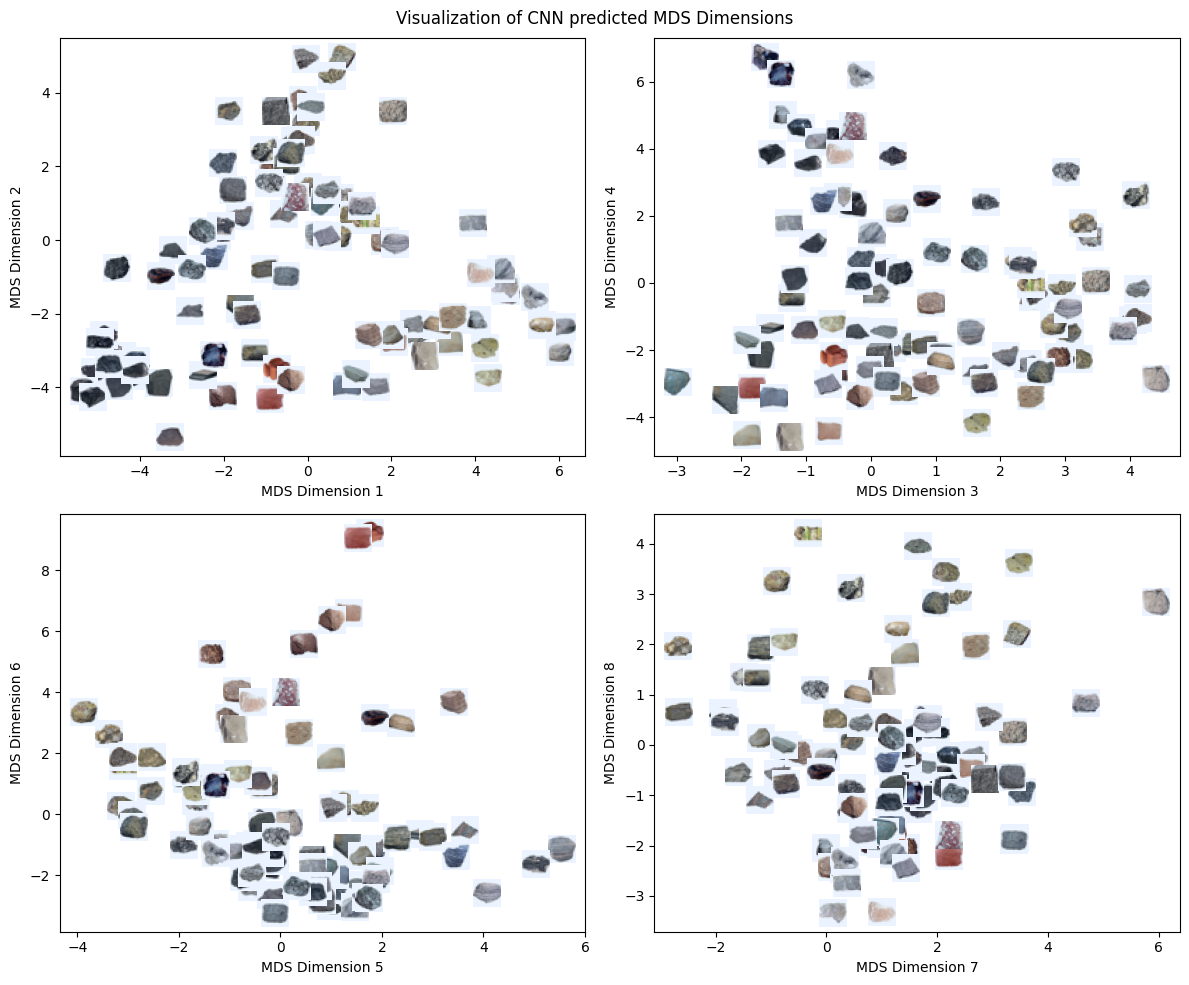

In [104]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from PIL import Image

images = X_validate
mds_coordinates = validate_prediction

min_val = -2.117904
max_val = 2.64

scaled_images = (images - min_val) / (max_val - min_val)
scaled_images = (scaled_images * 255).astype(np.uint8) 
scaled_images = np.clip(scaled_images, 0, 255)

# Create subplots for different pairs of dimensions
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Pairs of dimensions: (0, 1), (2, 3), (4, 5), (6, 7)
dimension_pairs = [(0, 1), (2, 3), (4, 5), (6, 7)]

for i, ax in enumerate(axes.flatten()):
    dimension_x, dimension_y = dimension_pairs[i]
    
    # Scatter plot of MDS coordinates
    ax.scatter(mds_coordinates[:, dimension_x], mds_coordinates[:, dimension_y], c='blue', alpha=0.5)
    
    # Function to display resized images
    def plot_resized_image(img, x, y, ax):
        img_copy = Image.fromarray(img)
        img_copy = img_copy.resize((20, 20))  # Resize images to fit within the subplot
        imagebox = OffsetImage(img_copy, zoom=1.0)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)
    
    # Plot each image at its respective MDS coordinates
    for j, (x, y) in enumerate(zip(mds_coordinates[:, dimension_x], mds_coordinates[:, dimension_y])):
        image = scaled_images[j]  # Get the image at index j
        plot_resized_image(image, x, y, ax)
    
    ax.set_xlabel(f'MDS Dimension {dimension_x+1}')
    ax.set_ylabel(f'MDS Dimension {dimension_y+1}')

plt.suptitle(f'Visualization of CNN predicted MDS Dimensions')
plt.tight_layout()
plt.show()


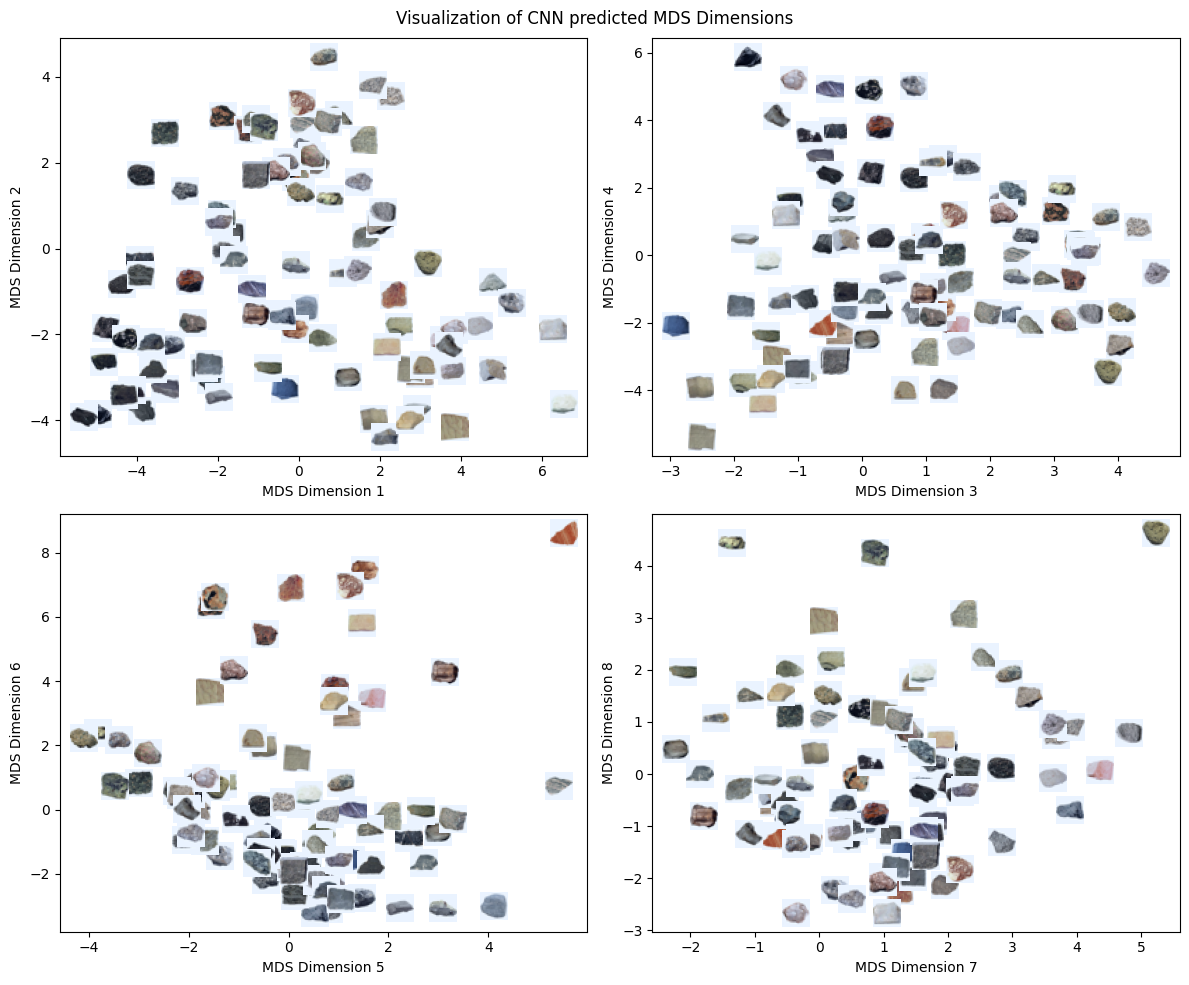

In [117]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from PIL import Image

images = X_test
mds_coordinates = test_prediction

min_val = -2.117904
max_val = 2.64

scaled_images = (images - min_val) / (max_val - min_val)
scaled_images = (scaled_images * 255).astype(np.uint8) 
scaled_images = np.clip(scaled_images, 0, 255)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

dimension_pairs = [(0, 1), (2, 3), (4, 5), (6, 7)]

for i, ax in enumerate(axes.flatten()):
    dimension_x, dimension_y = dimension_pairs[i]
    
    # Scatter plot of MDS coordinates
    ax.scatter(mds_coordinates[:, dimension_x], mds_coordinates[:, dimension_y], c='blue', alpha=0.5)
    
    # Function to display resized images
    def plot_resized_image(img, x, y, ax):
        img_copy = Image.fromarray(img)
        img_copy = img_copy.resize((20, 20))  # Resize images to fit within the subplot
        imagebox = OffsetImage(img_copy, zoom=1.0)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)
    
    # Plot each image at its respective MDS coordinates
    for j, (x, y) in enumerate(zip(mds_coordinates[:, dimension_x], mds_coordinates[:, dimension_y])):
        image = scaled_images[j]  # Get the image at index j
        plot_resized_image(image, x, y, ax)
    
    ax.set_xlabel(f'MDS Dimension {dimension_x+1}')
    ax.set_ylabel(f'MDS Dimension {dimension_y+1}')

plt.suptitle(f'Visualization of CNN predicted MDS Dimensions')
plt.tight_layout()
plt.show()


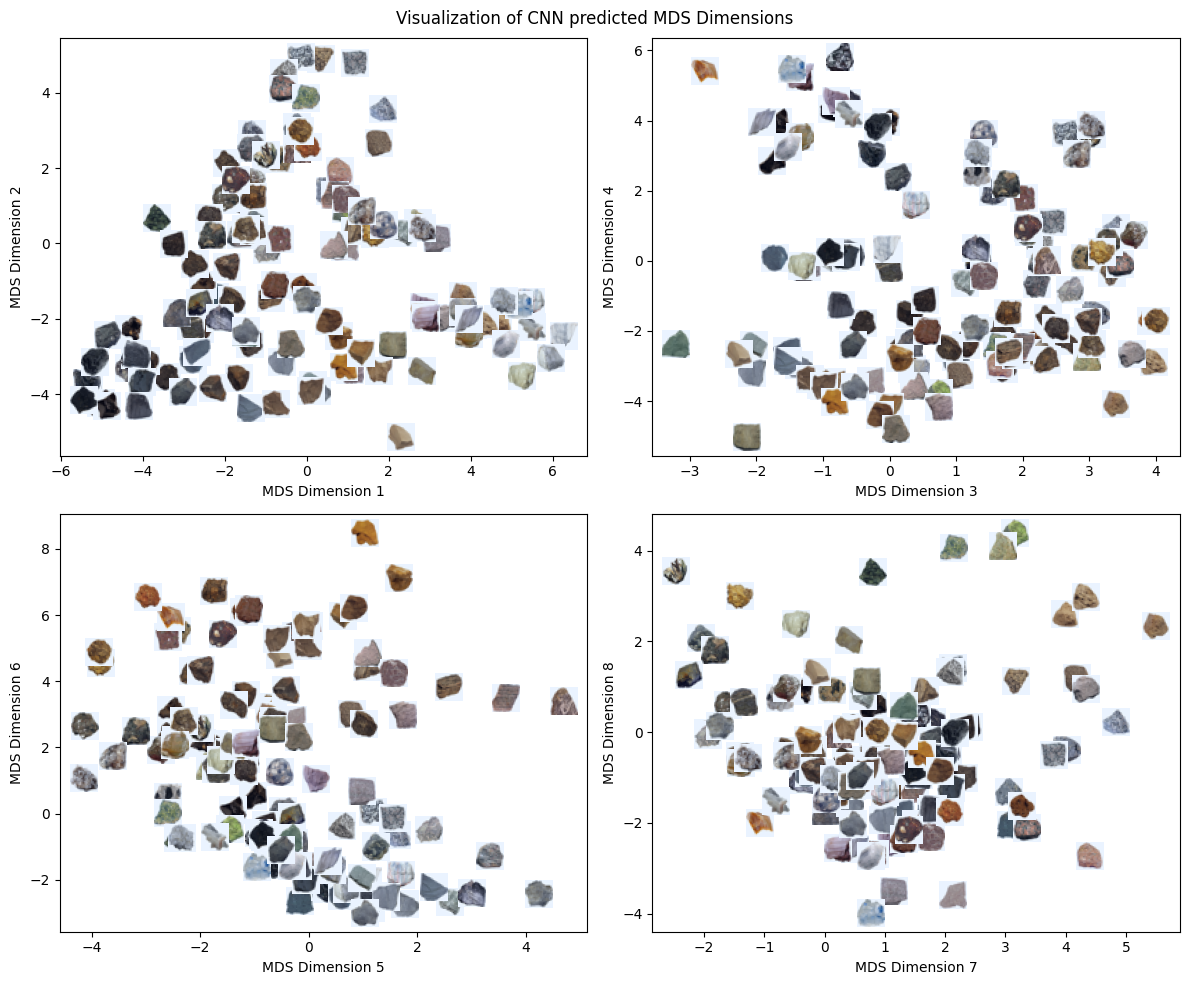

In [128]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from PIL import Image

images = X_120
mds_coordinates = rocks_120_prediction

min_val = -2.117904
max_val = 2.64

scaled_images = (images - min_val) / (max_val - min_val)
scaled_images = (scaled_images * 255).astype(np.uint8) 
scaled_images = np.clip(scaled_images, 0, 255)

# Create subplots for different pairs of dimensions
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Pairs of dimensions: (0, 1), (2, 3), (4, 5), (6, 7)
dimension_pairs = [(0, 1), (2, 3), (4, 5), (6, 7)]

for i, ax in enumerate(axes.flatten()):
    dimension_x, dimension_y = dimension_pairs[i]
    
    # Scatter plot of MDS coordinates
    ax.scatter(mds_coordinates[:, dimension_x], mds_coordinates[:, dimension_y], c='blue', alpha=0.5)
    
    # Function to display resized images
    def plot_resized_image(img, x, y, ax):
        img_copy = Image.fromarray(img)
        img_copy = img_copy.resize((20, 20))  # Resize images to fit within the subplot
        imagebox = OffsetImage(img_copy, zoom=1.0)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)
    
    # Plot each image at its respective MDS coordinates
    for j, (x, y) in enumerate(zip(mds_coordinates[:, dimension_x], mds_coordinates[:, dimension_y])):
        image = scaled_images[j]  # Get the image at index j
        plot_resized_image(image, x, y, ax)
    
    ax.set_xlabel(f'MDS Dimension {dimension_x+1}')
    ax.set_ylabel(f'MDS Dimension {dimension_y+1}')

plt.suptitle(f'Visualization of CNN predicted MDS Dimensions')
plt.tight_layout()
plt.show()


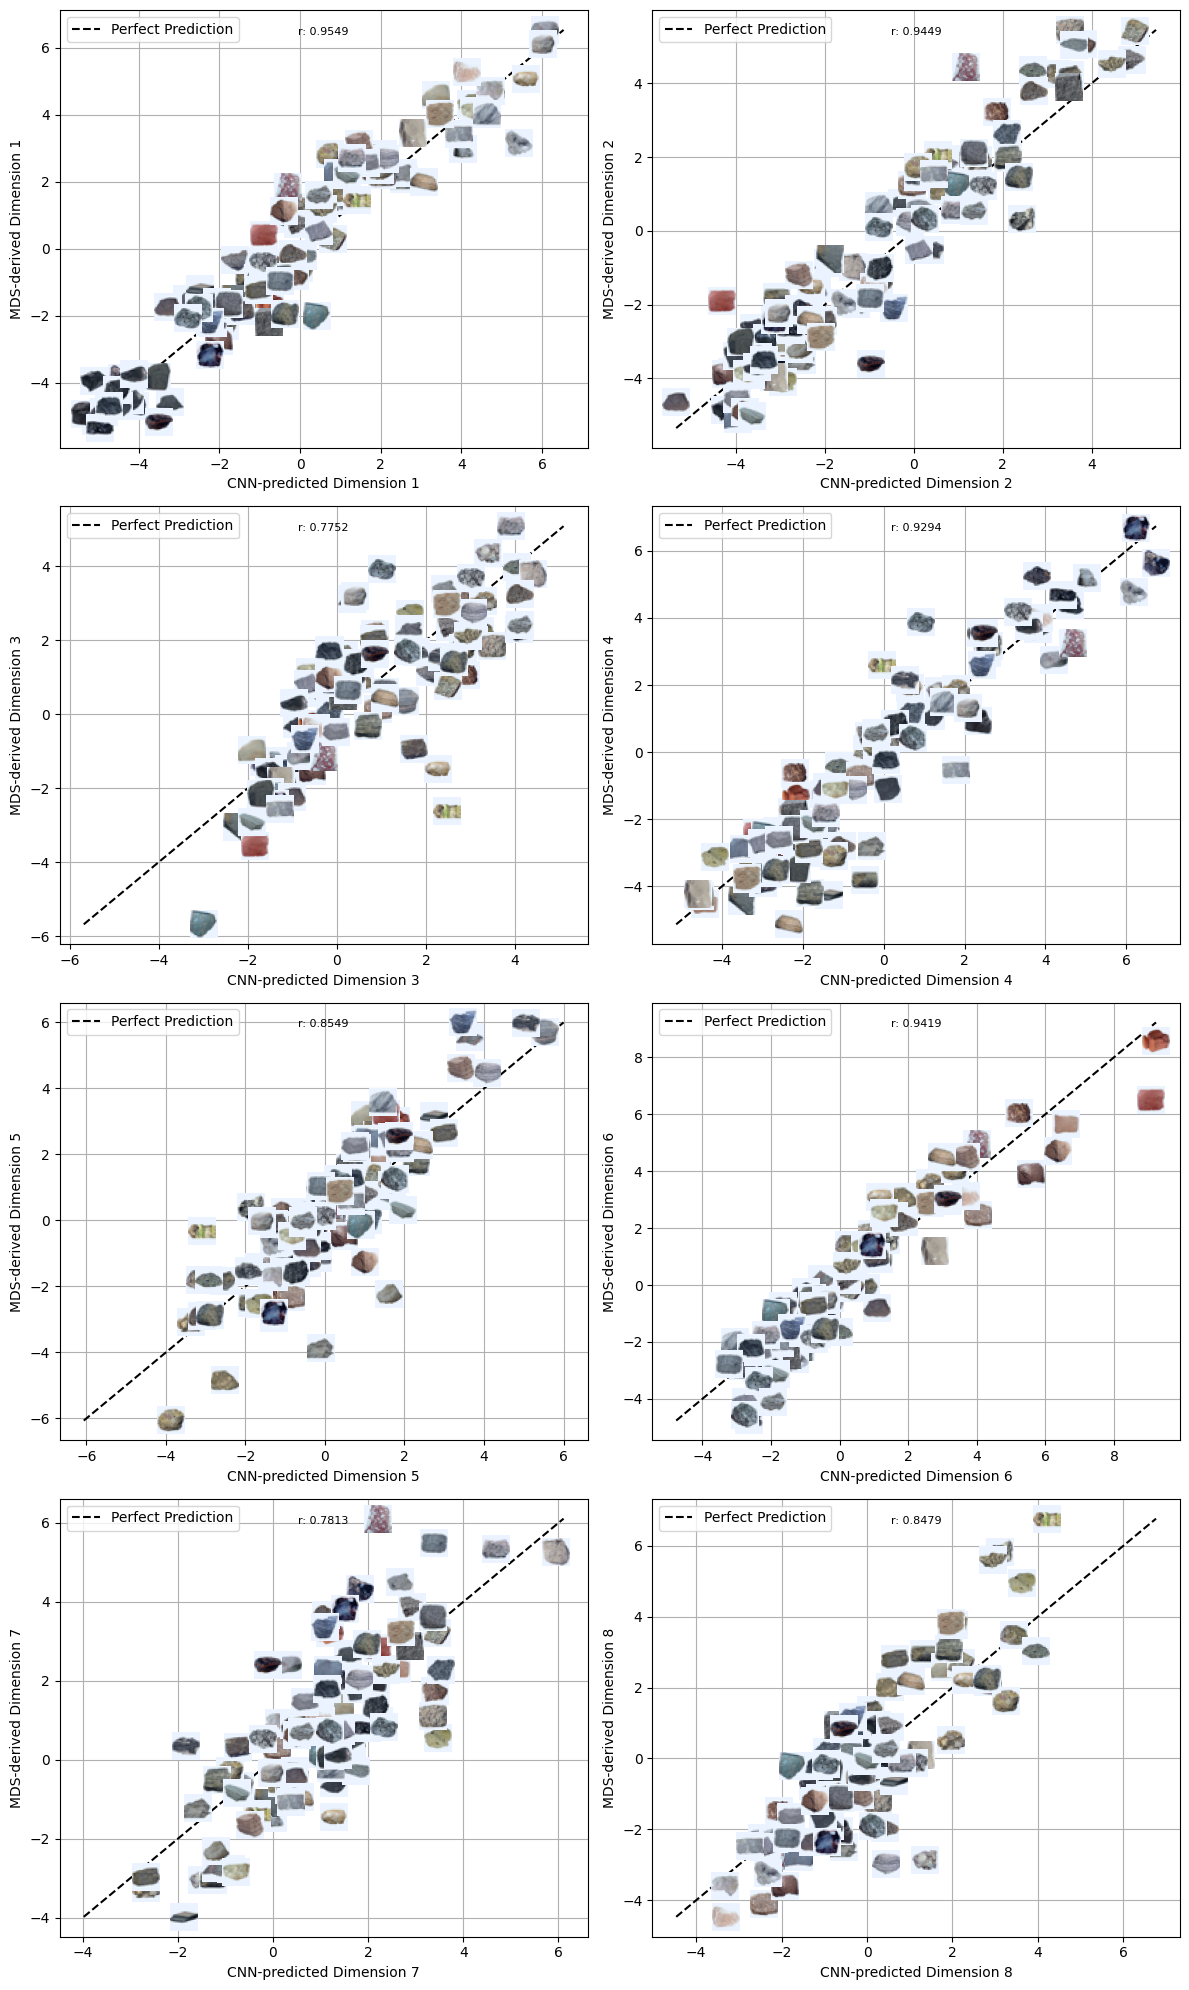

In [126]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from scipy.stats import pearsonr
from PIL import Image

images = X_validate
mds_cnn_coordinates = validate_prediction  
mds_actual_coordinates = Y_validate 

# Rescale images
min_val = -2.117904
max_val = 2.64
scaled_images = (images - min_val) / (max_val - min_val)
scaled_images = (scaled_images * 255).astype(np.uint8) 
scaled_images = np.clip(scaled_images, 0, 255)

# Calculate Pearson correlation coefficients for each dimension
correlation_coefficients = [pearsonr(mds_cnn_coordinates[:, i], mds_actual_coordinates[:, i])[0] for i in range(8)]

# Create subplots for each dimension
fig, axes = plt.subplots(4, 2, figsize=(12, 20))
# fig.suptitle("Scatterplots of CNN-predicted dimensions against MDS derived dimensions")
axes = axes.flatten()

for i in range(8):
    ax = axes[i]
    
    ax.scatter(mds_cnn_coordinates[:, i], mds_actual_coordinates[:, i], alpha=0.7)
    
    for j, (x_cnn, y_actual) in enumerate(zip(mds_cnn_coordinates[:, i], mds_actual_coordinates[:, i])):
        plot_resized_image(scaled_images[j], x_cnn, y_actual, ax)
    
    ax.plot(np.linspace(min(mds_actual_coordinates[:, i].min(), mds_cnn_coordinates[:, i].min()),
                        max(mds_actual_coordinates[:, i].max(), mds_cnn_coordinates[:, i].max()), 100),
            np.linspace(min(mds_actual_coordinates[:, i].min(), mds_cnn_coordinates[:, i].min()),
                        max(mds_actual_coordinates[:, i].max(), mds_cnn_coordinates[:, i].max()), 100),
            'k--', label='Perfect Prediction')
    
    ax.set_xlabel(f'CNN-predicted Dimension {i+1}')
    ax.set_ylabel(f'MDS-derived Dimension {i+1}')
    ax.legend()
    ax.grid(True)
    
    ax.text(0.5, 0.95, f"r: {correlation_coefficients[i]:.4f}", ha='center', va='center', transform=ax.transAxes, fontsize=8)

plt.tight_layout()
plt.show()


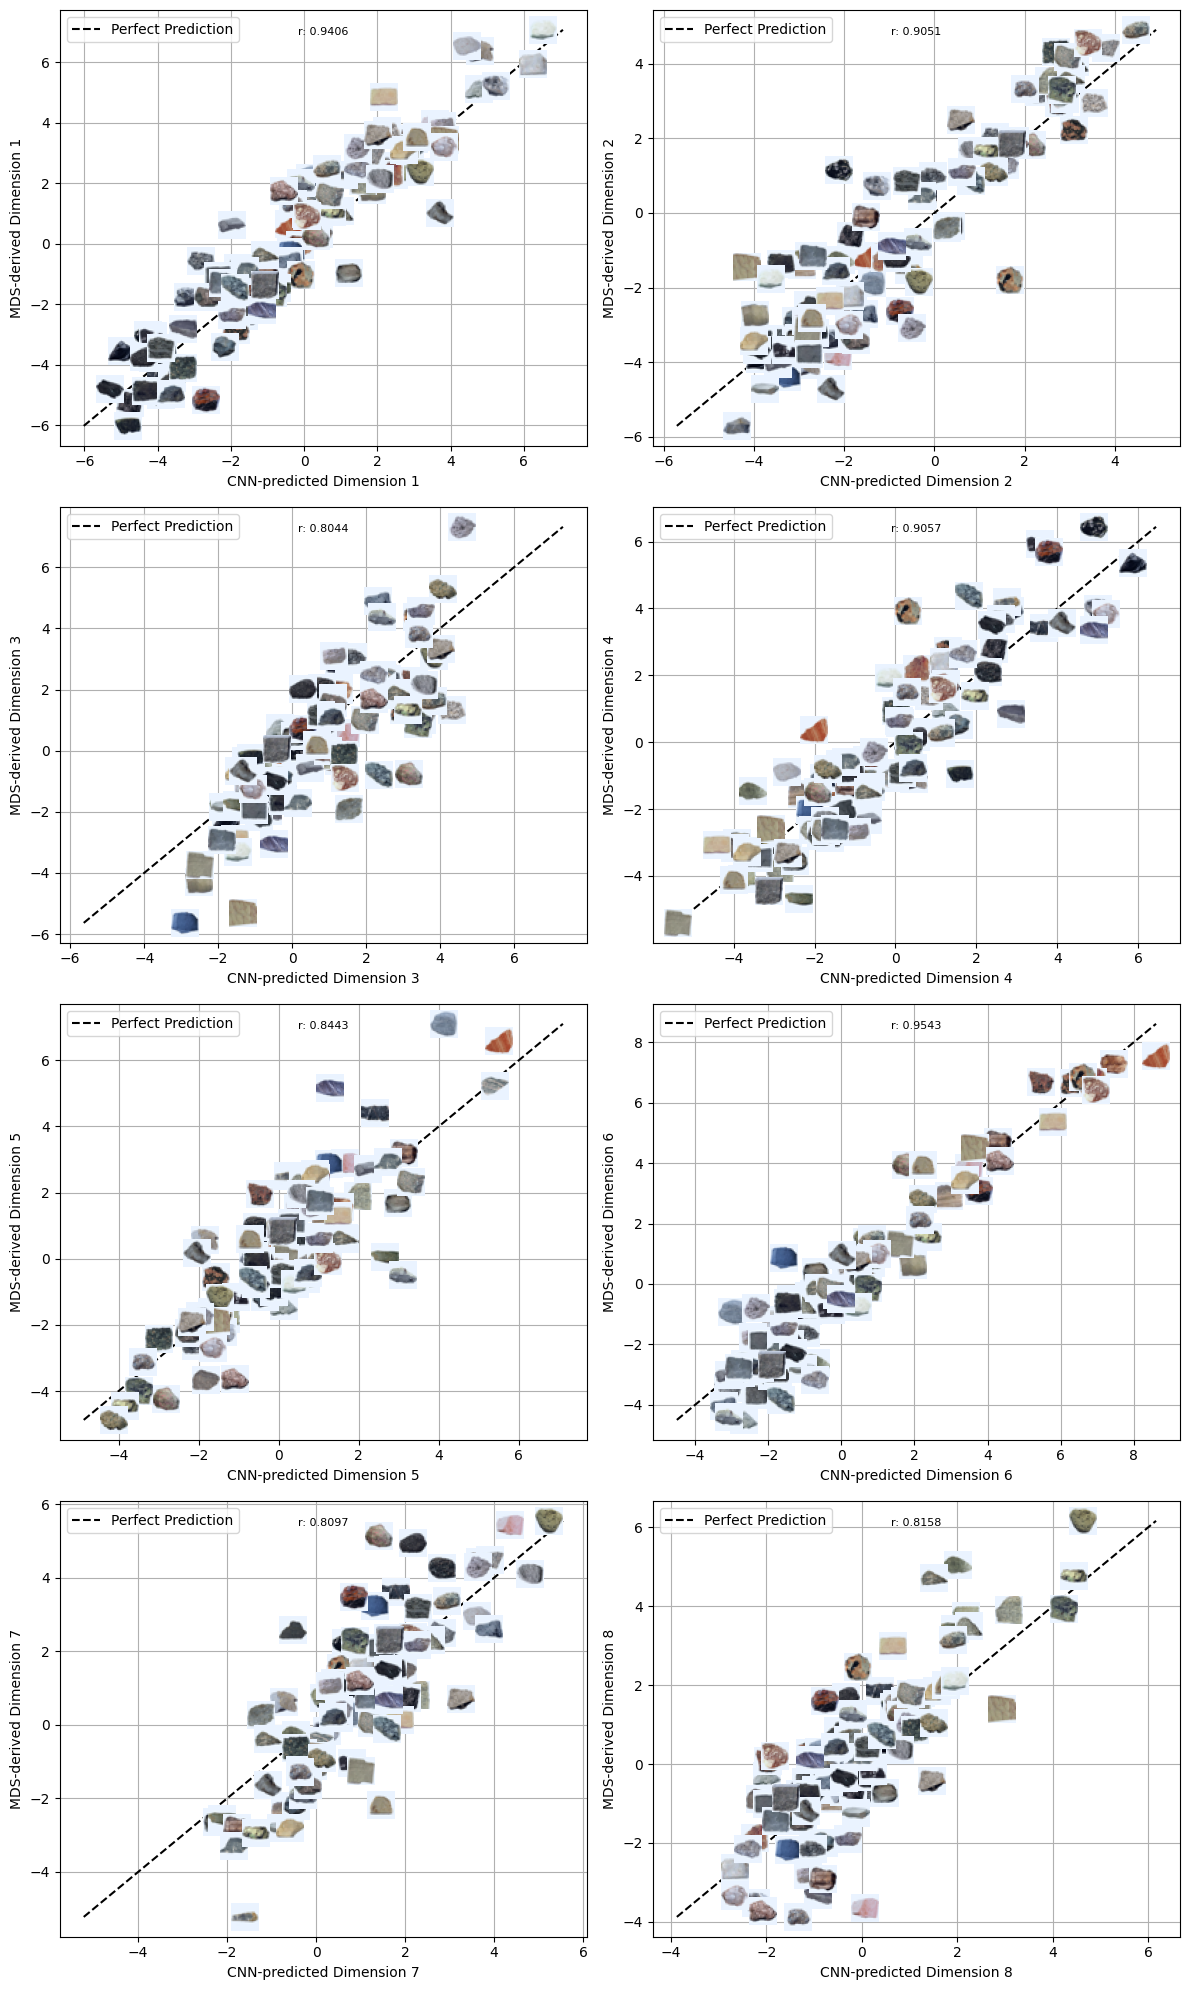

In [127]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from scipy.stats import pearsonr
from PIL import Image

images = X_test
mds_cnn_coordinates = test_prediction 
mds_actual_coordinates = Y_test  

# Rescale images
min_val = -2.117904
max_val = 2.64
scaled_images = (images - min_val) / (max_val - min_val)
scaled_images = (scaled_images * 255).astype(np.uint8) 
scaled_images = np.clip(scaled_images, 0, 255)

# Calculate Pearson correlation coefficients for each dimension
correlation_coefficients = [pearsonr(mds_cnn_coordinates[:, i], mds_actual_coordinates[:, i])[0] for i in range(8)]

# Create subplots for each dimension
fig, axes = plt.subplots(4, 2, figsize=(12, 20))
axes = axes.flatten()

for i in range(8):
    ax = axes[i]
    
    ax.scatter(mds_cnn_coordinates[:, i], mds_actual_coordinates[:, i], alpha=0.7)
    
    for j, (x_cnn, y_actual) in enumerate(zip(mds_cnn_coordinates[:, i], mds_actual_coordinates[:, i])):
        plot_resized_image(scaled_images[j], x_cnn, y_actual, ax)
    
    ax.plot(np.linspace(min(mds_actual_coordinates[:, i].min(), mds_cnn_coordinates[:, i].min()),
                        max(mds_actual_coordinates[:, i].max(), mds_cnn_coordinates[:, i].max()), 100),
            np.linspace(min(mds_actual_coordinates[:, i].min(), mds_cnn_coordinates[:, i].min()),
                        max(mds_actual_coordinates[:, i].max(), mds_cnn_coordinates[:, i].max()), 100),
            'k--', label='Perfect Prediction')
    
    ax.set_xlabel(f'CNN-predicted Dimension {i+1}')
    ax.set_ylabel(f'MDS-derived Dimension {i+1}')
    ax.legend()
    ax.grid(True)
    
    ax.text(0.5, 0.95, f"r: {correlation_coefficients[i]:.4f}", ha='center', va='center', transform=ax.transAxes, fontsize=8)

plt.tight_layout()
# plt.suptitle("Scatterplots of CNN-predicted dimensions against MDS derived dimensions")
plt.show()


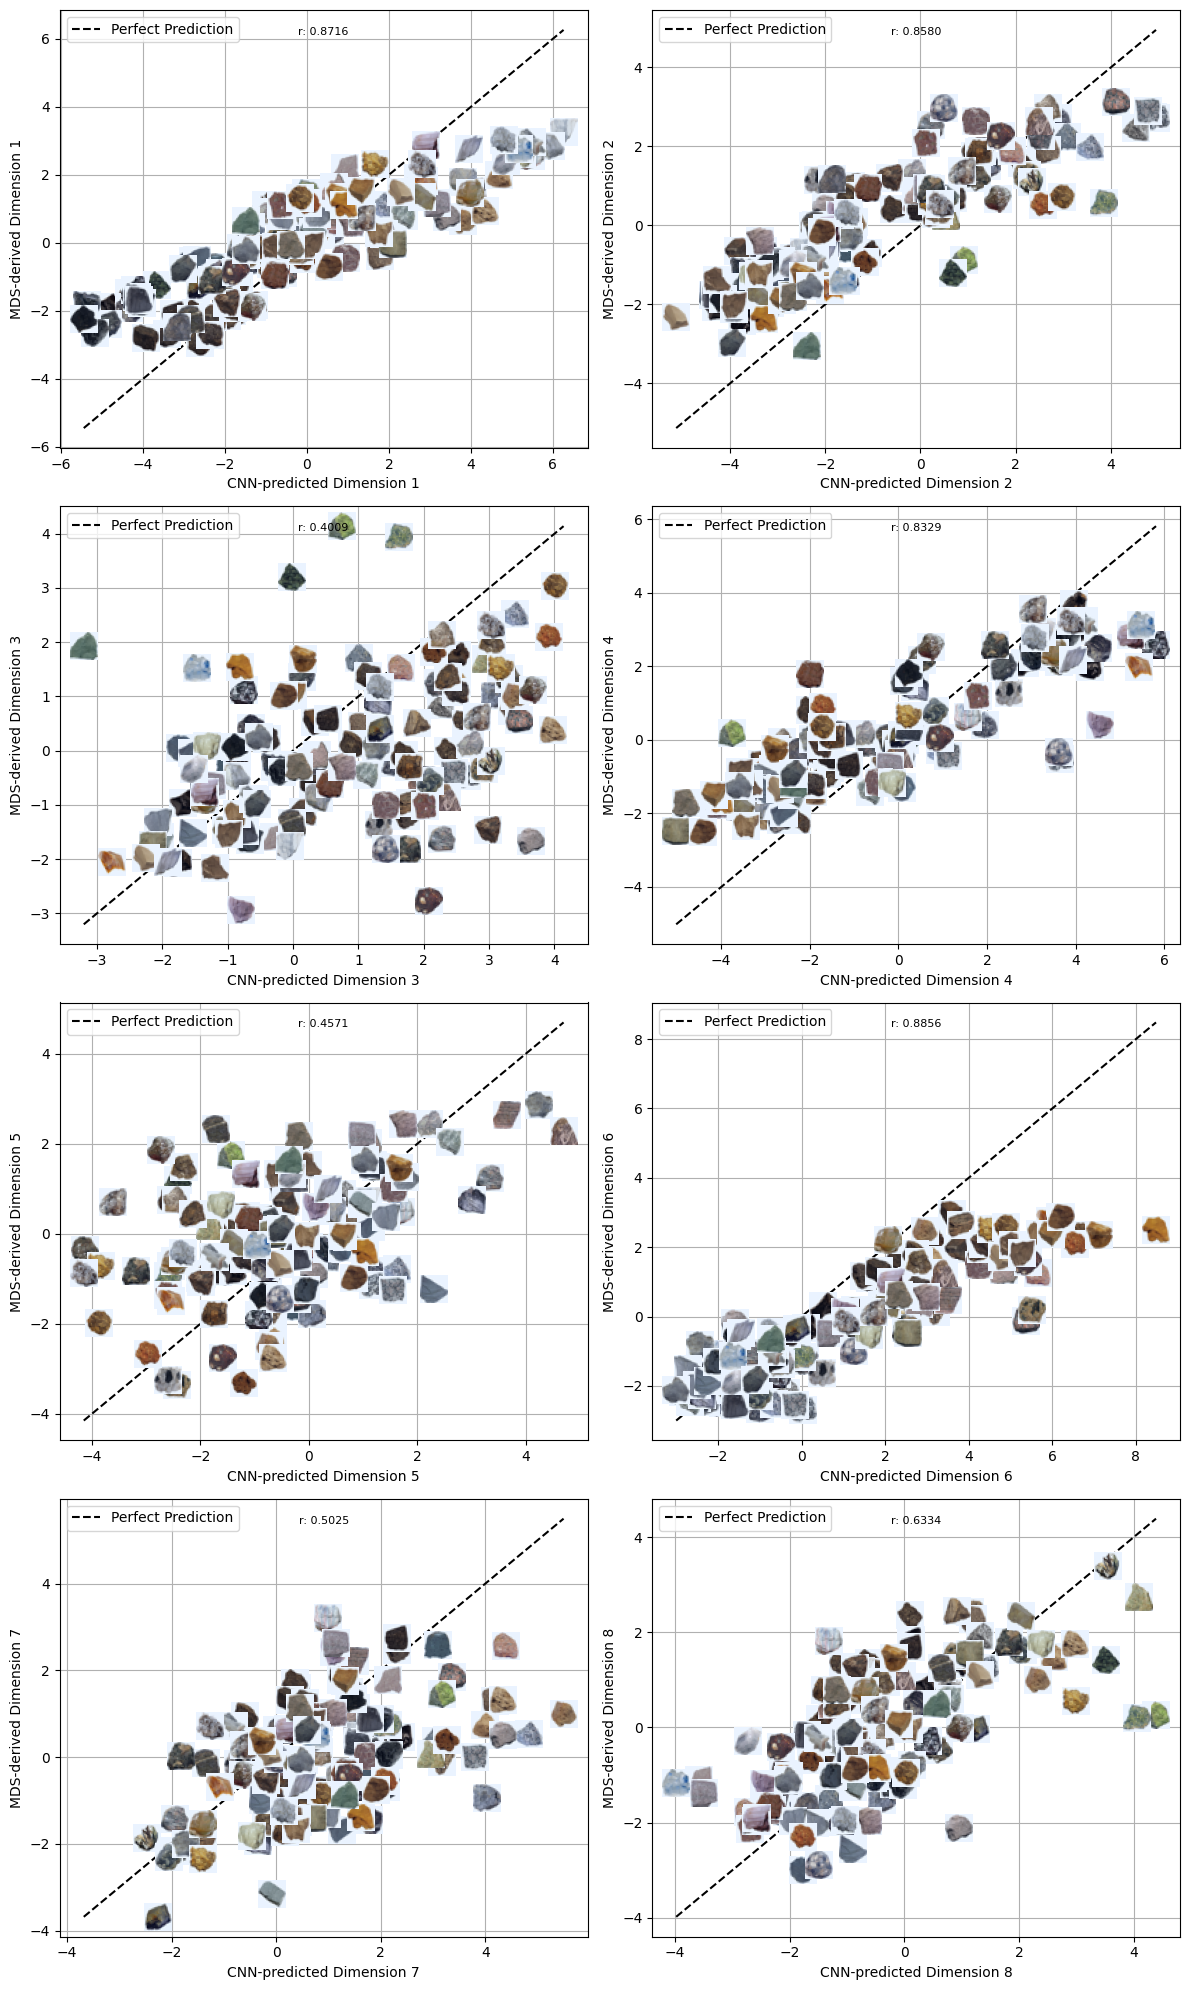

In [129]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from scipy.stats import pearsonr
from PIL import Image

images = X_120
mds_cnn_coordinates = rocks_120_prediction  
mds_actual_coordinates = Y_120 

# Rescale images
min_val = -2.117904
max_val = 2.64
scaled_images = (images - min_val) / (max_val - min_val)
scaled_images = (scaled_images * 255).astype(np.uint8) 
scaled_images = np.clip(scaled_images, 0, 255)

# Calculate Pearson correlation coefficients for each dimension
correlation_coefficients = [pearsonr(mds_cnn_coordinates[:, i], mds_actual_coordinates[:, i])[0] for i in range(8)]

# Create subplots for each dimension
fig, axes = plt.subplots(4, 2, figsize=(12, 20))
# fig.suptitle("Scatterplots of CNN-predicted dimensions against MDS derived dimensions")
axes = axes.flatten()

for i in range(8):
    ax = axes[i]
    
    ax.scatter(mds_cnn_coordinates[:, i], mds_actual_coordinates[:, i], alpha=0.7)
    
    for j, (x_cnn, y_actual) in enumerate(zip(mds_cnn_coordinates[:, i], mds_actual_coordinates[:, i])):
        plot_resized_image(scaled_images[j], x_cnn, y_actual, ax)
    
    ax.plot(np.linspace(min(mds_actual_coordinates[:, i].min(), mds_cnn_coordinates[:, i].min()),
                        max(mds_actual_coordinates[:, i].max(), mds_cnn_coordinates[:, i].max()), 100),
            np.linspace(min(mds_actual_coordinates[:, i].min(), mds_cnn_coordinates[:, i].min()),
                        max(mds_actual_coordinates[:, i].max(), mds_cnn_coordinates[:, i].max()), 100),
            'k--', label='Perfect Prediction')
    
    ax.set_xlabel(f'CNN-predicted Dimension {i+1}')
    ax.set_ylabel(f'MDS-derived Dimension {i+1}')
    ax.legend()
    ax.grid(True)
    
    ax.text(0.5, 0.95, f"r: {correlation_coefficients[i]:.4f}", ha='center', va='center', transform=ax.transAxes, fontsize=8)

plt.tight_layout()
plt.show()
